In [1]:
import os
import random
import collections
import operator
import itertools
import pickle
import tqdm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import simpleclock
import sklearn.metrics
import sklearn.decomposition

In [3]:
import torch
import torchtext

## Dataset, iterators

In [4]:
data_path = os.path.join(os.path.abspath(''), "data_cine_cleaned.csv")

In [5]:
TEXT = torchtext.data.Field(tokenize = "spacy",
                            tokenizer_language="fr_core_news_sm",
                            include_lengths=True)
LABEL = torchtext.data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=lambda x: float(x) / 5)
# labels are linearly rescaled to a 0-1 range
# todo: test if preprocessing data before isn't faster

In [6]:
dataset = torchtext.data.TabularDataset(path=data_path,
                                        format="CSV",
                                        fields={"critique": ("input", TEXT), "note": ("target", LABEL)})

In [7]:
data_train, data_test = dataset.split(split_ratio=0.8)

In [8]:
data_train, data_valid = data_train.split(split_ratio=0.8)

In [9]:
print(f"""training data: {len(data_train)} examples.
validation data: {len(data_valid)} examples.
test data: {len(data_test)} examples.""")

training data: 47095 examples.
validation data: 11774 examples.
test data: 14717 examples.


In [10]:
vectors = torchtext.vocab.Vectors("cc.fr.300.vec", os.path.join(os.path.expanduser("~"), "Downloads"))

In [11]:
VOCAB_MAX_SIZE = 70000
TEXT.build_vocab(data_train, max_size=VOCAB_MAX_SIZE, vectors=vectors)

In [12]:
DEVICE = torch.device("cuda")

In [13]:
BATCH_SIZE = 256

In [14]:
iter_train, iter_valid, iter_test = \
    torchtext.data.BucketIterator.splits(datasets=(data_train, data_valid, data_test),
                                         batch_size=BATCH_SIZE,
                                         device=DEVICE,
                                         sort_within_batch=True,
                                         sort_key=lambda example: len(example.input),
                                         sort=False)

## Model definition

In [15]:
class RNN(torch.nn.Module):
    def __init__(self, n_vocab, embedding_dim, hidden_dim, output_dim, dropout, bidirectional,
                 n_layers, pad_idx):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.bidirectional = bidirectional
        num_dir = 2 if bidirectional else 1
        self.embedding = torch.nn.Embedding(n_vocab, embedding_dim, padding_idx=pad_idx)
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim,
                                 bidirectional=bidirectional,
                                 num_layers=n_layers,
                                 dropout=dropout)
        self.fc = torch.nn.Linear(hidden_dim * num_dir, output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_lengths):
        input, lengths = input_lengths
        torch.nn.utils.rnn.pack_padded_sequence(input, lengths)
        embedded = self.embedding(input)  # ((sent_len, batch), emb_dim)
        packed_output, (hidden, cell) = self.rnn(embedded)  # hidden: (num_layers * num_directions,
                                                            #          batch, hidden_size * num_directions)
        hidden = (torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)
                  if self.bidirectional else hidden).squeeze(0)  # (batch, hidden_size * num_directions)
        return self.sigmoid(self.fc(self.dropout(hidden)))  # (batch, 1)

In [16]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
N_VOCAB = len(TEXT.vocab)

In [17]:
DEFAULT_PARAMS = {
    "n_vocab": N_VOCAB,
    "embedding_dim": 300,
    "hidden_dim": 256,
    "output_dim": 1,
    "dropout": 0.5,
    "bidirectional": True,
    "n_layers": 1,
    "pad_idx": PAD_IDX,
}

def default_model(**kwargs):
    _d = {}
    _d.update(DEFAULT_PARAMS)
    _d.update(kwargs)
    return RNN(**_d)

In [18]:
def pseudo_init(model, criterion, device=DEVICE, learn_embedding_param=True):
    model.embedding.weight.data.copy_(TEXT.vocab.vectors)
    model.embedding.weight.data[UNK_IDX] = torch.zeros(model.embedding_dim)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(model.embedding_dim)
    
    for name, param in model.named_parameters():
        if name == "embedding.weight":
            param.requires_grad = learn_embedding_param
    
    print("The model has {:,} trainable parameters"
         .format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    return model, criterion

In [19]:
def output_to_pred(output):
    return (output * 10).round() / 2

## Training utils

In [20]:
def accuracy(preds, y):
    correct = (preds == y).float()  # convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [21]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        output = model(batch.input).squeeze(1)
        loss = criterion(output, batch.target)
        loss.backward()
        optimizer.step()
        
        acc = accuracy(output_to_pred(output), batch.target * 5)
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
      
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            output = model(batch.input).squeeze(1)
            loss = criterion(output, batch.target)
            acc = accuracy(output_to_pred(output), batch.target * 5)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
class TrainInfo:
    def __init__(self, valid={}, train={}):
        self.valid = collections.defaultdict(lambda: [])
        self.valid.update(valid)
        self.train = collections.defaultdict(lambda: [])
        self.train.update(train)
    
    def save(self, path):
        packed = {
            "valid": dict(self.valid),
            "train": dict(self.train),
        }
        with open(path, "wb") as f:
            pickle.dump(packed, f)
    
    @classmethod
    def load(cls, path):
        with open(path, "rb") as f:
            packed = pickle.load(f)
            return cls(valid=packed["valid"],
                       train=packed["train"])
    
    @staticmethod
    def _dict_to_repr(d):
        return dict(map(lambda k_v: (k_v[0], f"{len(k_v[1])} elements"), d.items()))
    
    def __repr__(self):
        return pprint.pformat({"valid": self._dict_to_repr(self.valid),
                     "train": self._dict_to_repr(self.train),})

In [24]:
def do_training(model, name, iter_train, iter_valid, optimizer, criterion, fun_train,
                fun_eval, n_epochs=100, training_info=None, fun_stop=lambda: False):

    clock = simpleclock.Clock.started()
    torch.cuda.empty_cache()
    train_info = training_info if training_info is not None else TrainInfo()
    best_valid_loss = min(train_info.valid["loss"]) if train_info.valid["loss"] else float("inf")
    best_valid_acc = max(train_info.valid["acc"]) if train_info.valid["acc"] else 0
    print(f"Starting training: {n_epochs} epochs.")
    for epoch in range(n_epochs):
        if fun_stop():
            print("Interrupted. (fun_stop)")
            break

        clock.elapsed_since_start.call()  # meh

        train_loss, train_acc = fun_train(model, iter_train, optimizer, criterion)
        valid_loss, valid_acc = fun_eval(model, iter_valid, criterion)
        
        is_best_loss = valid_loss < best_valid_loss
        is_best_acc = valid_acc > best_valid_acc
        print("Epoch: {e:.<{max_len}}. T, V acc: {train:.1f}%, {valid:.1f}%. Took {t:.2f}s."
             .format(e=epoch + 1,
                     max_len=len(str(n_epochs)),
                     train=100 * train_acc,
                     valid=100 * valid_acc,
                     t=clock.elapsed_since_last_call())
             + (" (+)" if is_best_acc else "")
             )
        
        train_info.train["loss"].append(train_loss)
        train_info.valid["loss"].append(valid_loss)
        train_info.train["acc"].append(train_acc)
        train_info.valid["acc"].append(valid_acc)

        if is_best_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), f"{name}.pt")

    clock.elapsed_since_start.print(f"Trained {name}, {n_epochs} epochs, for")
    return train_info

In [25]:
class TrainSet:
    def __init__(self, model, name, iter_train, iter_valid,
                 fun_optimizer, fun_criterion, fun_train, fun_eval,
                 device=DEVICE, n_epochs=100, training_info=None, fun_stop=lambda: False):
        self.model = model
        self.name = name
        self.iter_train = iter_train
        self.iter_valid = iter_valid
        self.fun_optimizer = fun_optimizer
        self.fun_criterion = fun_criterion
        self.fun_train = fun_train
        self.fun_eval = fun_eval
        self.n_epochs = n_epochs
        self.device = device
        self.training_info = training_info
        self.fun_stop = fun_stop
        
        self.optimizer = None
        self.criterion = None
        
    def init(self, learn_embedding_param=True):
        self.model, self.criterion = pseudo_init(self.model, self.fun_criterion(), self.device,
                                                 learn_embedding_param=learn_embedding_param)
        self.optimizer = self.fun_optimizer(self.model.parameters())
    
    def do_training(self):
        if self.optimizer is None or self.criterion is None:
            raise Exception("It looks like an init is needed: optimizer or criterion is None")
        return do_training(model=self.model,
                           name=self.name,
                           iter_train=self.iter_train,
                           iter_valid=self.iter_valid,
                           optimizer=self.optimizer,
                           criterion=self.criterion,
                           fun_train=self.fun_train,
                           fun_eval=self.fun_eval,
                           n_epochs=self.n_epochs,
                           training_info=self.training_info,
                           fun_stop=self.fun_stop)

## Saving/loading utils

In [26]:
def save_vocab_embedding(path, vocab, embedding):
    with open(path, "w") as f:
        for word, vector in tqdm.tqdm(zip(vocab.itos, embedding)):
            
            # skip words with unicode symbols
            if len(word) != len(word.encode()):
                continue
            
            # 'words' like " " or "\n" fail to be loaded
            if word.strip() == "":
                continue

            f.write(f"{word} {' '.join(str(e) for e in vector.tolist())}\n")

In [27]:
def load_context(model, field, path_model, path_vocab, cache_embeddings="cache_embeddings", device=DEVICE):
    
    _vectors = torchtext.vocab.Vectors(path_vocab, cache_embeddings)  # voir unk_init
    field.build_vocab(data_train, max_size=VOCAB_MAX_SIZE, vectors=_vectors)
    
    model.load_state_dict(torch.load(path_model))
    
    model.embedding.weight.data.copy_(field.vocab.vectors)
    
    model = model.to(device)
    
    iter_train, iter_valid, iter_test = \
        torchtext.data.BucketIterator.splits(datasets=(data_train, data_valid, data_test),
                                             batch_size=BATCH_SIZE,
                                             device=DEVICE,
                                             sort_within_batch=True,
                                             sort_key=lambda example: len(example.input),
                                             sort=False)
    
    return model, (iter_train, iter_valid, iter_test)

In [28]:
def save_for_pred(folder_path, model, itos):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    torch.save(model.state_dict(), os.path.join(folder_path, "model.pt"))
    with open(os.path.join(folder_path, "itos.pickle"), "wb") as f:
        pickle.dump(itos, f)

In [29]:
def load_for_pred(folder_path, model, device=DEVICE):
    model.load_state_dict(torch.load(os.path.join(folder_path, "model.pt")))
    model = model.to(DEVICE)
    with open(os.path.join(folder_path, "itos.pickle"), "rb") as f:
        itos = pickle.load(f)
    stoi = collections.defaultdict(lambda: 0)
    stoi.update(map(lambda t: t[::-1], enumerate(itos)))
    return model, itos, stoi

## Training

In [125]:
train_sets = []
N_EPOCHS = 1000

for hidden_dim, n_layers in itertools.product([128], [4]):
    train_sets.append(TrainSet(
        model=default_model(hidden_dim=hidden_dim, n_layers=n_layers),
        name=f"rnn_hidden-{hidden_dim}_nlayers-{n_layers}_nepochs-{N_EPOCHS}",
        iter_train=iter_train,
        iter_valid=iter_valid,
        fun_optimizer=torch.optim.Adam,
        fun_criterion=torch.nn.MSELoss,
        fun_train=train,
        fun_eval=evaluate,
        n_epochs=N_EPOCHS,
        fun_stop=lambda: os.path.exists(".stop"),
    ))

The model has 18,741,669 trainable parameters
Starting training: 1000 epochs.
Epoch: 1.... T, V acc: 21.0%, 27.0%. Took 10.91s. (+)
Epoch: 2.... T, V acc: 29.7%, 23.6%. Took 10.86s.
Epoch: 3.... T, V acc: 32.4%, 24.8%. Took 10.95s.
Epoch: 4.... T, V acc: 36.2%, 21.7%. Took 10.83s.
Epoch: 5.... T, V acc: 43.8%, 25.5%. Took 10.87s.
Epoch: 6.... T, V acc: 52.5%, 25.8%. Took 10.86s.
Epoch: 7.... T, V acc: 59.2%, 26.3%. Took 10.88s.
Epoch: 8.... T, V acc: 64.5%, 27.3%. Took 10.92s. (+)
Epoch: 9.... T, V acc: 67.1%, 28.1%. Took 10.93s. (+)
Epoch: 10... T, V acc: 71.8%, 27.2%. Took 10.95s.
Epoch: 11... T, V acc: 76.4%, 28.0%. Took 10.92s.
Epoch: 12... T, V acc: 79.6%, 27.5%. Took 10.87s.
Epoch: 13... T, V acc: 81.3%, 28.8%. Took 10.89s. (+)
Epoch: 14... T, V acc: 82.2%, 29.2%. Took 10.90s. (+)
Epoch: 15... T, V acc: 83.0%, 29.5%. Took 10.89s. (+)
Epoch: 16... T, V acc: 83.9%, 29.7%. Took 10.89s. (+)
Epoch: 17... T, V acc: 86.1%, 31.2%. Took 10.90s. (+)
Epoch: 18... T, V acc: 88.7%, 31.8%. Too

Epoch: 161.. T, V acc: 99.4%, 42.8%. Took 10.94s.
Epoch: 162.. T, V acc: 99.4%, 42.4%. Took 10.96s.
Epoch: 163.. T, V acc: 99.4%, 42.3%. Took 10.92s.
Epoch: 164.. T, V acc: 99.4%, 42.3%. Took 10.93s.
Epoch: 165.. T, V acc: 99.5%, 42.7%. Took 10.97s.
Epoch: 166.. T, V acc: 99.5%, 42.9%. Took 10.99s.
Epoch: 167.. T, V acc: 99.5%, 42.8%. Took 10.87s.
Epoch: 168.. T, V acc: 99.5%, 43.0%. Took 10.93s.
Epoch: 169.. T, V acc: 99.4%, 42.9%. Took 10.94s.
Epoch: 170.. T, V acc: 99.4%, 43.1%. Took 10.95s.
Epoch: 171.. T, V acc: 99.4%, 43.0%. Took 10.95s.
Epoch: 172.. T, V acc: 99.4%, 43.4%. Took 10.91s. (+)
Epoch: 173.. T, V acc: 99.4%, 42.4%. Took 10.92s.
Epoch: 174.. T, V acc: 99.3%, 42.7%. Took 11.00s.
Epoch: 175.. T, V acc: 99.4%, 43.3%. Took 10.94s.
Epoch: 176.. T, V acc: 99.4%, 43.0%. Took 10.95s.
Epoch: 177.. T, V acc: 99.3%, 42.0%. Took 10.96s.
Epoch: 178.. T, V acc: 99.4%, 43.2%. Took 10.95s.
Epoch: 179.. T, V acc: 99.4%, 43.0%. Took 10.95s.
Epoch: 180.. T, V acc: 99.5%, 43.0%. Took 10.9

Epoch: 325.. T, V acc: 99.6%, 42.8%. Took 10.91s.
Epoch: 326.. T, V acc: 99.7%, 42.8%. Took 10.93s.
Epoch: 327.. T, V acc: 99.7%, 43.3%. Took 10.90s.
Epoch: 328.. T, V acc: 99.7%, 43.5%. Took 10.94s.
Epoch: 329.. T, V acc: 99.6%, 42.8%. Took 10.86s.
Epoch: 330.. T, V acc: 99.5%, 42.7%. Took 10.91s.
Epoch: 331.. T, V acc: 99.6%, 42.5%. Took 10.90s.
Epoch: 332.. T, V acc: 99.6%, 42.8%. Took 10.89s.
Epoch: 333.. T, V acc: 99.7%, 42.9%. Took 10.96s.
Epoch: 334.. T, V acc: 99.6%, 42.6%. Took 10.90s.
Epoch: 335.. T, V acc: 99.6%, 42.6%. Took 10.89s.
Epoch: 336.. T, V acc: 99.7%, 42.8%. Took 10.86s.
Epoch: 337.. T, V acc: 99.7%, 43.1%. Took 10.92s.
Epoch: 338.. T, V acc: 99.6%, 42.6%. Took 10.91s.
Epoch: 339.. T, V acc: 99.6%, 42.7%. Took 10.92s.
Epoch: 340.. T, V acc: 99.7%, 42.6%. Took 10.88s.
Epoch: 341.. T, V acc: 99.7%, 42.5%. Took 10.92s.
Epoch: 342.. T, V acc: 99.6%, 42.6%. Took 10.95s.
Epoch: 343.. T, V acc: 99.6%, 43.2%. Took 10.86s.
Epoch: 344.. T, V acc: 99.6%, 43.5%. Took 10.93s.


Epoch: 489.. T, V acc: 99.7%, 43.4%. Took 10.61s.
Epoch: 490.. T, V acc: 99.7%, 42.7%. Took 10.58s.
Epoch: 491.. T, V acc: 99.7%, 43.1%. Took 10.58s.
Epoch: 492.. T, V acc: 99.7%, 43.2%. Took 10.90s.
Epoch: 493.. T, V acc: 99.6%, 43.1%. Took 10.89s.
Epoch: 494.. T, V acc: 99.7%, 42.8%. Took 10.93s.
Epoch: 495.. T, V acc: 99.7%, 43.2%. Took 10.92s.
Epoch: 496.. T, V acc: 99.7%, 43.1%. Took 10.93s.
Epoch: 497.. T, V acc: 99.7%, 42.3%. Took 10.91s.
Epoch: 498.. T, V acc: 99.7%, 43.1%. Took 10.92s.
Epoch: 499.. T, V acc: 99.7%, 43.1%. Took 10.91s.
Epoch: 500.. T, V acc: 99.7%, 43.5%. Took 10.90s.
Epoch: 501.. T, V acc: 99.7%, 43.0%. Took 10.91s.
Epoch: 502.. T, V acc: 99.8%, 43.2%. Took 10.90s.
Epoch: 503.. T, V acc: 99.7%, 43.6%. Took 10.90s.
Epoch: 504.. T, V acc: 99.7%, 43.2%. Took 10.95s.
Epoch: 505.. T, V acc: 99.7%, 43.5%. Took 10.91s.
Epoch: 506.. T, V acc: 99.7%, 42.7%. Took 10.91s.
Epoch: 507.. T, V acc: 99.7%, 43.0%. Took 10.92s.
Epoch: 508.. T, V acc: 99.7%, 43.0%. Took 10.91s.


Epoch: 653.. T, V acc: 99.7%, 43.2%. Took 10.71s.
Epoch: 654.. T, V acc: 99.7%, 43.5%. Took 10.63s.
Epoch: 655.. T, V acc: 99.7%, 43.9%. Took 10.68s.
Epoch: 656.. T, V acc: 99.7%, 44.0%. Took 10.93s.
Epoch: 657.. T, V acc: 99.8%, 43.8%. Took 10.92s.
Epoch: 658.. T, V acc: 99.8%, 43.5%. Took 10.73s.
Epoch: 659.. T, V acc: 99.8%, 43.5%. Took 10.91s.
Epoch: 660.. T, V acc: 99.8%, 43.8%. Took 10.91s.
Epoch: 661.. T, V acc: 99.7%, 43.2%. Took 10.96s.
Epoch: 662.. T, V acc: 99.7%, 43.3%. Took 10.89s.
Epoch: 663.. T, V acc: 99.7%, 43.9%. Took 10.96s.
Epoch: 664.. T, V acc: 99.8%, 43.7%. Took 10.92s.
Epoch: 665.. T, V acc: 99.8%, 43.5%. Took 10.69s.
Epoch: 666.. T, V acc: 99.7%, 43.5%. Took 10.63s.
Epoch: 667.. T, V acc: 99.7%, 43.8%. Took 10.63s.
Epoch: 668.. T, V acc: 99.7%, 43.6%. Took 10.90s.
Epoch: 669.. T, V acc: 99.7%, 43.6%. Took 10.91s.
Epoch: 670.. T, V acc: 99.7%, 43.9%. Took 10.96s.
Epoch: 671.. T, V acc: 99.8%, 43.9%. Took 10.91s.
Epoch: 672.. T, V acc: 99.7%, 43.7%. Took 10.90s.


Epoch: 817.. T, V acc: 99.7%, 43.1%. Took 11.02s.
Epoch: 818.. T, V acc: 99.7%, 43.2%. Took 10.90s.
Epoch: 819.. T, V acc: 99.7%, 43.2%. Took 10.96s.
Epoch: 820.. T, V acc: 99.8%, 43.1%. Took 10.94s.
Epoch: 821.. T, V acc: 99.7%, 43.3%. Took 10.96s.
Epoch: 822.. T, V acc: 99.8%, 43.1%. Took 10.92s.
Epoch: 823.. T, V acc: 99.7%, 42.9%. Took 10.92s.
Epoch: 824.. T, V acc: 99.7%, 43.2%. Took 10.92s.
Epoch: 825.. T, V acc: 99.7%, 43.3%. Took 10.91s.
Epoch: 826.. T, V acc: 99.8%, 42.9%. Took 10.92s.
Epoch: 827.. T, V acc: 99.7%, 42.7%. Took 10.89s.
Epoch: 828.. T, V acc: 99.8%, 42.7%. Took 10.92s.
Epoch: 829.. T, V acc: 99.8%, 43.2%. Took 10.91s.
Epoch: 830.. T, V acc: 99.8%, 43.2%. Took 10.94s.
Epoch: 831.. T, V acc: 99.8%, 42.4%. Took 10.90s.
Epoch: 832.. T, V acc: 99.8%, 42.7%. Took 10.94s.
Epoch: 833.. T, V acc: 99.7%, 42.6%. Took 10.93s.
Epoch: 834.. T, V acc: 99.7%, 43.1%. Took 10.93s.
Epoch: 835.. T, V acc: 99.7%, 43.1%. Took 10.89s.
Epoch: 836.. T, V acc: 99.8%, 43.3%. Took 10.92s.


Epoch: 981.. T, V acc: 99.8%, 43.2%. Took 10.95s.
Epoch: 982.. T, V acc: 99.8%, 43.1%. Took 10.89s.
Epoch: 983.. T, V acc: 99.8%, 43.3%. Took 10.93s.
Epoch: 984.. T, V acc: 99.8%, 43.2%. Took 10.88s.
Epoch: 985.. T, V acc: 99.7%, 43.3%. Took 10.94s.
Epoch: 986.. T, V acc: 99.7%, 43.0%. Took 10.89s.
Epoch: 987.. T, V acc: 99.8%, 43.1%. Took 10.90s.
Epoch: 988.. T, V acc: 99.7%, 43.4%. Took 10.88s.
Epoch: 989.. T, V acc: 99.7%, 42.8%. Took 10.88s.
Epoch: 990.. T, V acc: 99.7%, 43.2%. Took 10.92s.
Epoch: 991.. T, V acc: 99.7%, 43.0%. Took 10.93s.
Epoch: 992.. T, V acc: 99.7%, 43.1%. Took 10.94s.
Epoch: 993.. T, V acc: 99.7%, 43.1%. Took 10.95s.
Epoch: 994.. T, V acc: 99.8%, 42.9%. Took 10.92s.
Epoch: 995.. T, V acc: 99.7%, 43.4%. Took 10.90s.
Epoch: 996.. T, V acc: 99.7%, 43.4%. Took 10.93s.
Epoch: 997.. T, V acc: 99.8%, 43.1%. Took 10.89s.
Epoch: 998.. T, V acc: 99.7%, 43.5%. Took 10.92s.
Epoch: 999.. T, V acc: 99.7%, 43.4%. Took 10.91s.
Epoch: 1000. T, V acc: 99.7%, 43.4%. Took 10.94s.


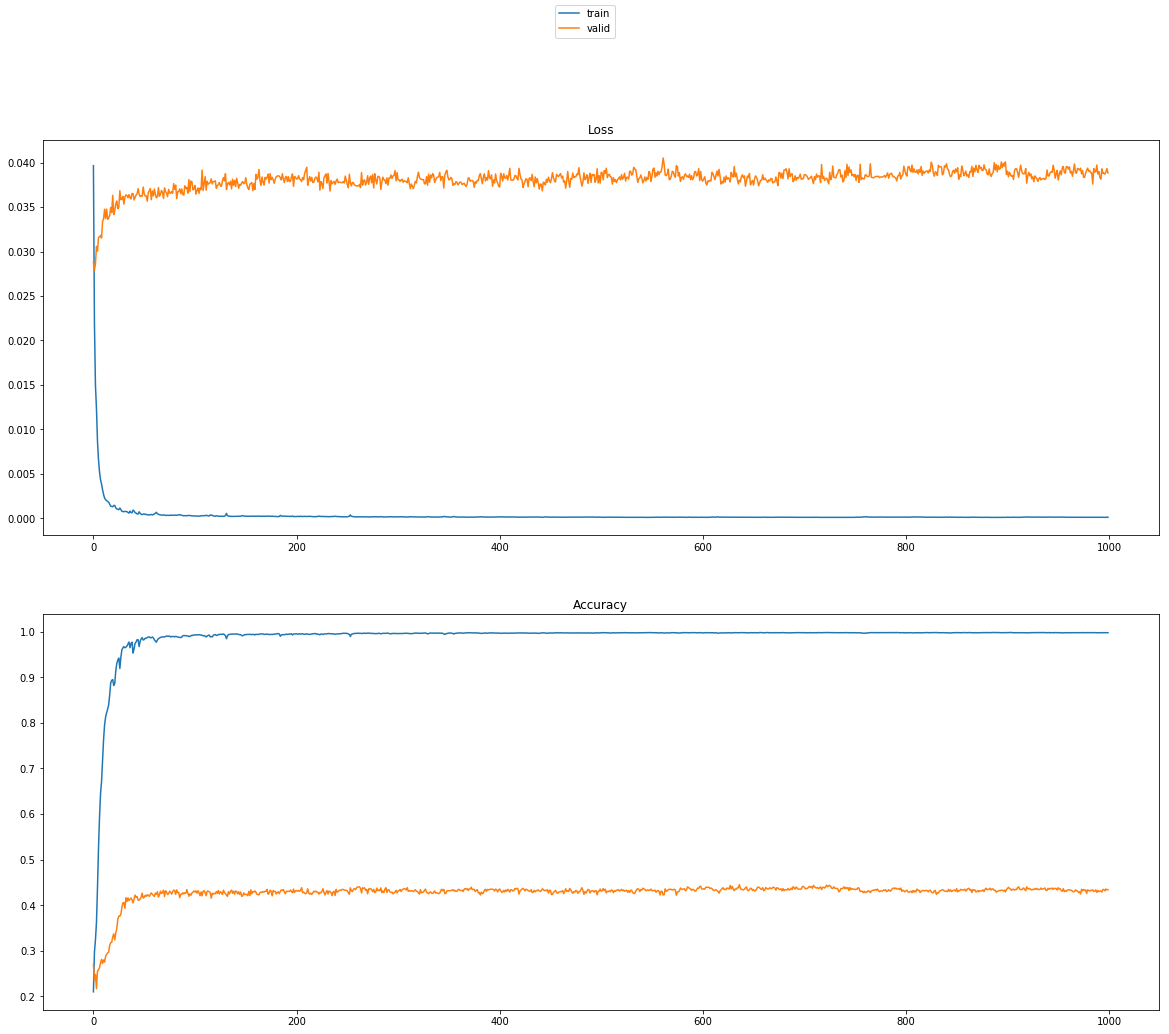

In [126]:
for train_set in train_sets:
    train_set.init()
    training_info = train_set.do_training()
    
    # save
    folder_path = os.path.join(os.path.abspath(""), f"dump_{train_set.name}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    training_info.save(os.path.join(folder_path, f"training_info.pickle"))
    save_for_pred(folder_path, train_set.model, TEXT.vocab.itos)
    
    # plot loss data ## todo: handle different data lengths?
    fig, axs = plt.subplots(2, 1, figsize=(20, 16))
    _n = len(training_info.train["loss"])
    ax_train = axs[0].plot(list(range(_n)), training_info.train["loss"], label="train")
    ax_valid = axs[0].plot(list(range(_n)), training_info.valid["loss"], label="valid")
    axs[0].set_title("Loss")
    ax_train = axs[1].plot(list(range(_n)), training_info.train["acc"], label="train")
    ax_valid = axs[1].plot(list(range(_n)), training_info.valid["acc"], label="valid")
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')
    axs[1].set_title("Accuracy")
    plt.show()

## Peeking

In [30]:
import spacy

nlp = spacy.load('fr_core_news_sm')

In [31]:
def predict_tokens(tokens, model, stoi, device=DEVICE):
    model.eval()
    idxs = [stoi[t] for t in tokens]
    inp = torch.LongTensor(idxs).reshape(-1, 1).to(device)
    output = output_to_pred(model((inp, torch.LongTensor([len(tokens)]))))
    return output.item()


def predict(sentence, model, stoi=TEXT.vocab.stoi, tokenizer=nlp.tokenizer):
    return predict_tokens(list(map(str, tokenizer(sentence))), model, stoi)

class Predictor:
    def __init__(self, model, stoi=TEXT.vocab.stoi, tokenizer=nlp.tokenizer, device=DEVICE):
        self.model = model
        self.stoi = stoi
        self.tokenizer = tokenizer
        self.device = device
    
    def predict(self, sentence):
        return predict(sentence, self.model, self.stoi, self.tokenizer)
    
    def predict_tokens(self, tokens):
        return predict_tokens(tokens, self.model, self.stoi, self.device)
    
    def __call__(self, sentence):
        return self.predict(sentence)

In [32]:
model, itos, stoi = load_for_pred("dump_rnn_hidden-128_nlayers-4_nepochs-1000",
                                  default_model(n_vocab=57051,
                                                hidden_dim=128,
                                                n_layers=4))

In [127]:
# model = train_set.model

In [46]:
predictor = Predictor(model, stoi=stoi)

In [48]:
predictor("Un mauvais film."), \
predictor("Un bon film.")

(1.0, 4.0)

In [49]:
for example in random.sample(list(data_train), 1000):
    tokens, note = example.input, float(example.target)
    if note * 5 != predictor.predict_tokens(tokens):
        print(" ".join(tokens))
        print(f"true) {note * 5} - {predictor.predict_tokens(tokens)} (pred")

Dévitalisée de toute affect déstabilisant , cette réalisation proprette fait contresens au propos putride , dérangeant et trivial d’ origine .
true) 1.0 - 4.0 (pred
Peter Weir , hélas , ne parvient qu' à édulcorer les hypothèses du scénario et la prestation extrêmement limitée de Jim Carrey achève de ternir le projet . 28/10/1998
true) 2.0 - 3.0 (pred
Sans doute l' œuvre la moins inspirée de son réalisateur , " The Search " n' en demeure pas moins un film capable de véhiculer des émotions fortes et durables .
true) 3.0 - 4.0 (pred
D' autant que d' un point de vue cinématographique ( réalisation , musique , décors , lumière ) , tout cela est , sans être désagréable , tout à fait anecdotique et déjà vu .
true) 2.0 - 3.0 (pred
Non que la qualité ne soit pas au rendez - vous , bien au contraire ( ... ) . Le problème , c' est la longueur du film ( 2h40 , quand même ) et le manque de surprise .
true) 3.0 - 2.0 (pred
Ce qui frappe à l' issue d'"Endgame " , c' est son sens de l' achèvement .
t

Si la forme est magique , « Le bon gros géant » ne restera pas dans les mémoires comme le classique qu' il aurait pu être . Il manque quelque chose au récit , un « danger » , une tension , un vrai suspense .
true) 2.0 - 3.0 (pred
C' est plutôt léger .
true) 2.0 - 3.0 (pred
Un à un , les clichés sont désamorcés . Jenkins accompagne d' ailleurs pour cela la sobriété de son scénario d' une bande originale quasi lyrique et d' éloquents silences qui font toute la force du film .
true) 5.0 - 4.0 (pred
Il vaut surtout pour son interprétation : Kevin Spacey et Kate Winslet sont excellents .
true) 3.0 - 2.0 (pred
Alors bien sûr , les raisonneurs , les culs - pincés , les curistes , les sédentaires , les fans de cinéma congelé et les abonnés des salles en velours rouge trouveront ces ogres trop exubérants , trop rabelaisiens , trop felliniens , trop hurleurs , trop partageurs , trop généreux . Mais on les plaint . Ils sont déjà morts , et Léa Fehner est vivante . Applaudissements .
true) 5.0 - 4

Cet " Hunger Games"-là est intime , souvent confiné entre les quatre murs du quartier général rebelle , et repose entièrement sur les épaules de Jennifer Lawrence .
true) 3.0 - 4.0 (pred
( ... ) le meilleur blockbuster de l' année . Une réussite qui doit plus aux talents de conteur de Bryan Singer qu' aux effets spéciaux ou pyrotechniques .
true) 5.0 - 4.0 (pred
( ... ) une réussite qui ne pouvait être que collective .
true) 4.0 - 5.0 (pred
Les dialogues fusent , les sourires sont ultra bright , l' humour plus british que yankee , et si l' on n' est pas regardant sur le script , c' est un pur moment de bonheur .
true) 3.0 - 4.0 (pred
Ecouter parler son coeur ou se laisser guider par sa raison , à vous de voir ! Vingt ans après , ce grand classique reste un plaisir pour les grands comme pour les petits .
true) 5.0 - 4.0 (pred
Ben Stiller est l' abruti dont on rêvait : ado attardé , Pierre Richard râblé , le petit taureau explose dans le grotesque .
true) 3.0 - 2.0 (pred
( ... ) Il n' es

La manière ludique et anxieuse qu’ a le film d’ agiter questions et problèmes en les rendant très concrets et néanmoins fantastiques est le privilège de ce duo de cinéastes dont on ne peut que dire ici à quel point il est regrettable qu’ ils mettent tant de temps avant de réapparaître entre chaque projet .
true) 4.0 - 3.0 (pred
Si on sent que la génèse du film en limite la réussite , ce " Casse - Noisette et les Quatre Royaumes " est riche d' une direction artistique d' orfèvre et d' une belle candeur alliant espoir et mélancolie .
true) 3.0 - 4.5 (pred
( ... ) Michael Haneke ne fera jamais l' unanimité : voir des personnages s' entredéchirer n' est pas forcément un spectacle souhaitable pour tous . Cependant , la leçon de cinéma que vous recevrez à la vision du film vaut largement l' effort de rentrer dans ce type de film ...
true) 4.0 - 3.0 (pred
Vu la réussite explosive du Time and Tide de son ami Tsui Hark , revenu au bercail après un séjour hollywoodien rien moins qu' amer , on pe

true) 3.0 - 2.0 (pred
( ... ) ce deuxième film non seulement commence dans l' action , mais tient ce rythme jusqu' au bout .
true) 5.0 - 3.5 (pred
Dommage qu’ ici ou là , quelques débordements de sentimentalisme affadissent un film qui se veut aussi tendre que mal pensant . Charlize Theron , elle , paie de sa personne .
true) 3.0 - 2.0 (pred
Un petit " Little Miss Sunshine " sur la lagune qui sent bon les vacances .
true) 4.0 - 3.0 (pred
Stephen Chow revient à ce qu' il sait faire de mieux : des gags fauchés , un comique de situation bricolé avec trois bouts de ficelle . Et , quand il donne dans la démesure , c' est plutôt sur l' énormité du comique que sur celle d' effets spéciaux à gros budget , même si le film n' en manque pas . En général , ça marche , avec une fantaisie et une fraîcheur rares . Parfois non . Ce n' est pas grave , et puis il sera difficile à Stephen Chow de changer .
true) 4.0 - 3.0 (pred
Au final , Alexandra Leclère , qui voulait sans doute , quelque part , parler

true) 3.0 - 2.0 (pred
On est , cette fois , franchement dans la comédie , la farce même , et les deux stars jouent le jeu avec talent , excès compris . Leur engagement donne de la vie à une partition trop calculée et qui finit par devenir un peu mécanique .
true) 3.0 - 3.5 (pred
" Teen Spirit " est un énième succédané de Flashdance qui aurait pris acte de l’ existence de " The Voice " , depuis 1983 , et qu’ il est permis de mettre des sources de lumière fluo dans le champ depuis Nicolas Winding Refn ( " Drive " ) .
true) 2.0 - 4.0 (pred
" La Fille du train " , alias Emily Blunt , déraille sur toute la ligne . Invraisemblable , ennuyeux et vulgaire .
true) 1.0 - 4.0 (pred
Une comédie douce - amère sur les relations parents - enfants , les non-dits , l' apprentissage de l' amour et la découverte de soi .
true) 5.0 - 3.0 (pred
Un récit pédagogique , complémentaire du film que Jonathan Teplitzky a consacré à l’ homme d’ État ( ... ) . Gary Oldman , méconnaissable , est stupéfiant .
true) 3

### Learned word vectors

In [37]:
X = model.embedding.weight.data.clone().cpu()

In [71]:
X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0428, -0.2596,  0.2624,  ..., -0.1652,  0.1987, -0.1074],
        [-0.1588,  0.0275,  0.2508,  ..., -0.3852, -0.0205,  0.1591],
        ...,
        [-0.0041,  0.0039, -0.0423,  ...,  0.0091, -0.0049,  0.0085],
        [ 0.0898, -0.0799,  0.0380,  ...,  0.0877, -0.0658, -0.0705],
        [-0.0811, -0.3167, -0.1976,  ..., -0.3005, -0.1955,  0.0877]])

In [86]:
def keep_word(word):
    return 4 < len(word) < 16

N_WORDS = 400

word_indexes = [i for i, word in enumerate(itos) if keep_word(word)]
word_indexes = random.sample(word_indexes, min(N_WORDS, len(word_indexes)))

In [87]:
pca = sklearn.decomposition.PCA(n_components=2)

In [88]:
Y = X[word_indexes]

In [89]:
pca.fit(Y)
Z = pca.transform(Y)

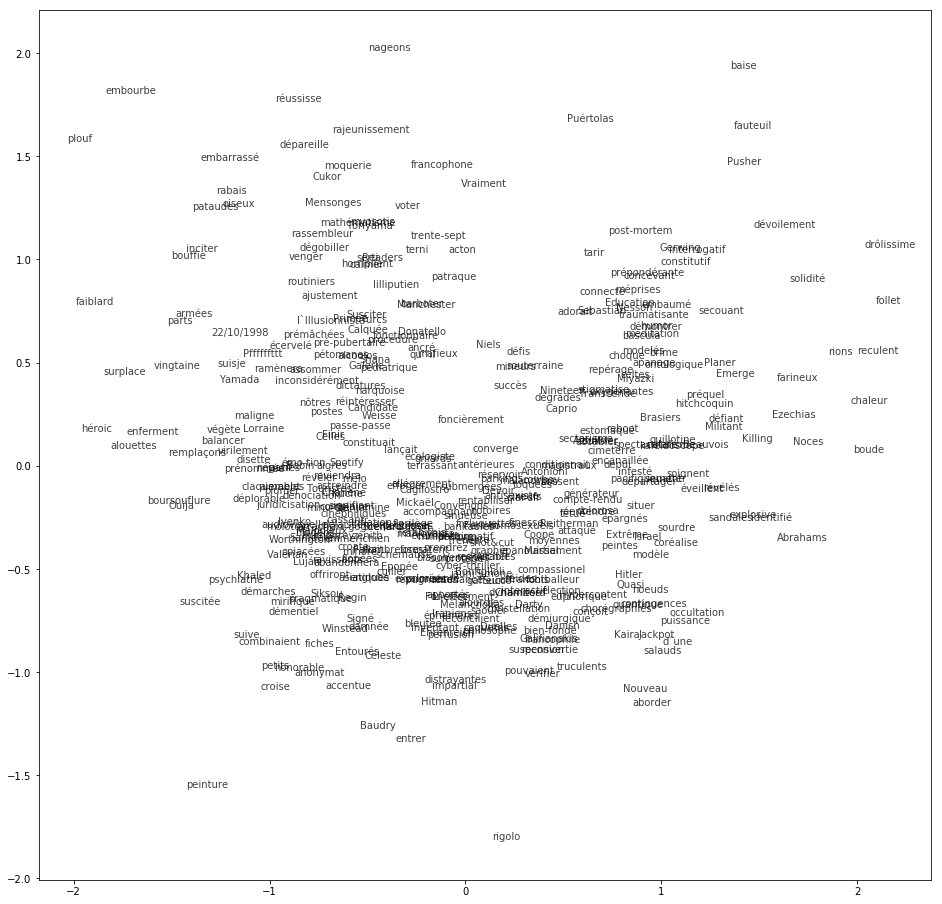

In [90]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter(Z[:, 0], Z[:, 1], color="white")
for i, row in zip(word_indexes, Z):
    ax.text(*row, itos[i], horizontalalignment="center", alpha=.75)
plt.show()

## Looser accuracies for evaluation

Is the model really doing bad if it predicts a 4.5 instead of a 5 ? There are at least two ways to allow for forgivable divergence with the test data :
* decrease notation's granularity, e.g. tranform the marks into good/bad, or good/bad/neutral.
* consider a prediction correct if it belongs to a 'small' interval containing the true value.

### Good/Neutral/Bad prediction

In [50]:
def normalized_to_3_way(pred_tensor, bad_treshold=.375, good_treshold=.625):
    """np array with values: 0: bad, 1: neutral, 2: good"""
    return np.digitize(pred_tensor.cpu().detach().numpy(), [bad_treshold, good_treshold])
    
def eval_accuracy_3w(model, iterator):
    n_examples = 0
    n_success = 0
    for batch in iterator:
        predictions = model(batch.input).squeeze(1)
        n_examples += len(batch)
        n_success += sum(normalized_to_3_way(predictions) == normalized_to_3_way(batch.target))
    return n_success / n_examples

def classif_report_3w(model, iterator):
    def preds_and_trues_to_array(predictions, true_targets):
        return np.concatenate([normalized_to_3_way(true_targets).reshape(-1, 1),
                               normalized_to_3_way(predictions).reshape(-1, 1)], axis=1)
    
    array = None
    for batch in iterator:
        predictions = model(batch.input).squeeze(1)
        
        if array is None:
            array = preds_and_trues_to_array(predictions, batch.target)
        else:
            array = np.concatenate([array,
                                    preds_and_trues_to_array(predictions, batch.target)], axis=0)
    print(sklearn.metrics.classification_report(array[:, 0],
                                                array[:, 1],
                                                labels=[0, 1, 2],
                                                target_names=["bad", "neutral", "good"]))

In [51]:
iterator = iter_test

classif_report_3w(model, iterator)


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

### Fuzzy accuracy

In [52]:
def eval_accuracy_fuzzy(model, iterator, fuzziness=.1):
    n_examples = 0.
    n_success = 0.
    for batch in iterator:
        predictions = model(batch.input).squeeze(1)
        n_examples += len(batch)
        n_success += sum(torch.abs(predictions - batch.target) <= fuzziness).item()
    return n_success / n_examples

In [53]:
eval_accuracy_fuzzy(model, iter_test, fuzziness=.21)

RuntimeError: CUDA error: device-side assert triggered

In [83]:
xs = np.linspace(0, .5, 50)

In [84]:
accs = [eval_accuracy_fuzzy(model, iter_test, fuzziness=x) for x in xs]

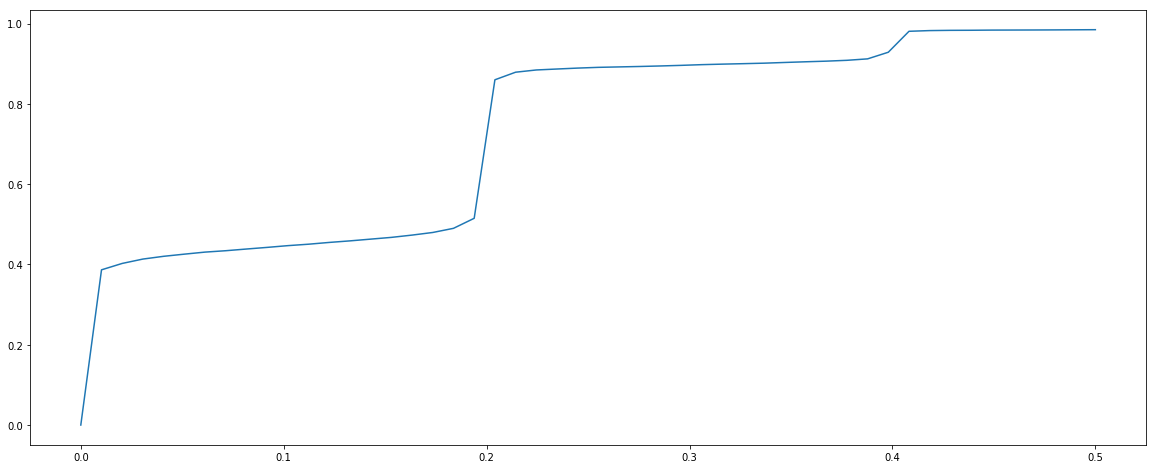

In [85]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(xs, accs)

## Vocab differences

In [45]:
unks = sents = 0
for batch in iter_train:
    sentences = batch.input[0]
    unks += (sentences == 0).sum().item()
    sents += batch.batch_size
print(f"avg number of <unk> per sentence: {unks / sents}")

avg number of <unk> per sentence: 0.0


In [46]:
print(itos[10000:10010])
print(TEXT.vocab.itos[10000:10010])

NameError: name 'itos' is not defined

In [ ]:
diff = set(itos).symmetric_difference(TEXT.vocab.itos)

In [ ]:
len(diff)